[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/niteshjindal-7/Challenge_LLM_for_Insurance_Claim_Automation/blob/main/code/Mdl3_pretrained_bert_embeddings_NN.ipynb)

## Import Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import nltk
import transformers
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
from gensim.models import Word2Vec, word2vec
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
from transformers import DistilBertTokenizer
from PIL import Image
import natsort
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
from matplotlib.collections import PatchCollection
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import clip

import torch
from transformers import AutoTokenizer, DistilBertModel
import time
import random
import tensorflow as tf
import transformers
import os
import pandas as pd
import natsort
import numpy as np
from PIL import Image
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.losses import mse
from keras import backend as K
from tensorflow.keras.layers import Dropout
import torch.nn as nn
TF_ENABLE_ONEDNN_OPTS=0

2023-08-23 11:00:18.362765: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
os.getcwd()
# os.chdir("/home/nitesh/Documents/MY_THESIS/MAMI/TRAINING")

'/home/nitesh/Documents/MY_THESIS/MAMI'

In [3]:
def export_classification_report(report, mod, eval_set=None):
    lines = report.split('\n')
    data = lines[2:4] + lines[5:9]
    data = [line.split() for line in data]
    
    acc = float(data[2][1])
    m_prec = float(data[3][2])
    m_recall = float(data[3][3])
    m_f1 = float(data[3][4])
    w_prec = float(data[4][2])
    w_recall = float(data[4][3])
    w_f1 = float(data[4][4])
    
    df = pd.DataFrame({
        'Model': [mod],
        'EvalSet': [eval_set],
        'Accuracy': [acc],
        'M-Precision': [m_prec],
        'M-Recall': [m_recall],
        'M-F1-Score': [m_f1],
        'W-Precision': [w_prec],
        'W-Recall': [w_recall],
        'W-F1-Score': [w_f1],
    }) 
    
    return df

# Function to apply text perturbation
def apply_text_perturbation(text):
    words = text.split()  # Split the text into words
    perturbed_words = []
    for word in words:
        # Apply perturbation to each word
        if random.random() < 0.2:  # 20% chance of perturbing a word
            perturbed_word = ""
            for char in word:
                if char in ["a", "e", "i", "o", "u"]:
                    perturbed_char = chr(ord(char) + 32)  # Replace vowel with a space
                else:
                    perturbed_char = char
                perturbed_word += perturbed_char

            perturbed_words.append(perturbed_word)
    perturbed_text = " ".join(perturbed_words)  # Join the perturbed words back into a text
    return perturbed_text

In [4]:
# Load the data
#  DistilBERT Embeddings (Text Only); (Train and Test Data Embeddings)

train2 = pd.read_csv('./training1.csv', delimiter='\t')

IDs = []  #set1
images = []
directory = 'TRAINING'   # directory where we have images 
filenames = natsort.natsorted(os.listdir(directory))  

# get the ids from the images, where images are having three channels; omit images if channels != 3
for i, filename in enumerate(filenames):
#     print(i, filename)
    if filename.endswith(".jpg"):
#         ID = int(filename[:-4])
        ID = filename
        pathname = os.path.join(directory, filename)
        im = Image.open(pathname)
        im = im.resize((224, 224))  # Resize the image to (224, 224)
        imnp = np.array(im)
        if len(imnp.shape) != 3:
#             print("This is 1 channel, so we omit it", imnp.shape, filename)
            continue
        IDs.append(ID)
        images.append(imnp)

def get_common_strings(list1, list2):
    return list(set(list1) & set(list2))

# Example usage
list1 = IDs
list2 = list(train2.file_name)  #from the text file where we have text description 
common_strings = get_common_strings(list1, list2)
print('len of common strings', len(common_strings))

sorted_ids = natsort.natsorted(common_strings)

# print(sorted_ids)

# Sort the dataframe with natural ordering of the IDs
train2['prefix_file_name'] = train2['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
sorted_train_df = train2.sort_values(by='prefix_file_name', ascending=True)
sorted_train_df

# Assuming 'df' is your DataFrame and 'common_strings' is the list of strings
# Get the common string values in the column 
filtered_df = sorted_train_df[sorted_train_df['file_name'].isin(sorted_ids)].reset_index(drop=True)

# Print the filtered DataFrame
print('filtered_df shape', filtered_df.shape)

train3 = filtered_df.copy()
# print(train3.shape)

trainx = train3.rename(columns={'Text Transcription': 'text'})
# display(trainx)



### LOAD TEST DATA

test1 = pd.read_csv('Test.csv', delimiter='\t')
test_labels = pd.read_csv('test_labels.txt', 
                          delimiter='\t',
                         header=None)

test_labels.columns = ['file_name', 
                      "misogynous",
                       "shaming",
                       "stereotype",
                       "objectification",
                       "violence"]

merged_test = pd.merge(test1, test_labels, on='file_name', how='inner')


# Sort the dataframe with natural ordering of the IDs
merged_test['prefix_file_name'] = merged_test['file_name'].str.extract('(\d+)').astype(int)
# Assuming 'df' is your DataFrame
merged_test1 = merged_test.sort_values(by='prefix_file_name', ascending=True)
merged_test1


# # train = train.rename(columns={'Text Transcription': 'text'})
test2 = merged_test1.rename(columns={'Text Transcription': 'text'})
# test2



# ######################################################
train = trainx[['file_name', 'text', 'misogynous']]
train = train.rename(columns = {'misogynous':'label'})

test = test2[['file_name', 'text', 'misogynous']]
test = test.rename(columns = {'misogynous':'label'})

train['label'] = train['label'].map({0: 'non_misogyn', 1: 'misogyn'})
test['label'] = test['label'].map({0: 'non_misogyn', 1: 'misogyn'})
display(train)
display(test)

len of common strings 9986
filtered_df shape (9986, 8)


,file_name,text,label
0,1.jpg,Milk Milk.zip,non_misogyn
1,2.jpg,-What are you doing? -you told me to satanize ...,non_misogyn
2,3.jpg,imgflip.com ME 1254 NEW BUGS AFTER CHANGES BUG...,non_misogyn
3,4.jpg,Bedroom Kitchen Bathroom Bron memes storage,non_misogyn
4,5.jpg,WAKEUP EARLY FREELANCERS,non_misogyn
...,...,...,...
9981,15002.jpg,WAITING FOR THE END OF THE COVID imgflip.com,non_misogyn
9982,15003.jpg,SMART WOMEN ARE AROUND imgflip.com,non_misogyn
9983,15004.jpg,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com,non_misogyn
9984,15005.jpg,COOKING FOR MY WIFE imgflip.com,non_misogyn


,file_name,text,label
436,15001.jpg,G HIS. UNDYING FIDELITY Steve is hot and perfe...,non_misogyn
854,15002.jpg,How limagined myself as a Teacher...... How I ...,non_misogyn
743,15004.jpg,WHERE WILL YOU BE WHEN DIARRHEA STRIKE memecen...,non_misogyn
44,15005.jpg,A MAN WITH DREAMS... NEEDS A WOMAN WITH VISION,non_misogyn
873,15006.jpg,THIS IS HOW YOUR GIRLFRIEND SEES YOUR FEMALE F...,non_misogyn
...,...,...,...
871,17078.jpg,There are multiple reasons to lower your car T...,non_misogyn
683,17079.jpg,MICHELLE OBAMA IS A MAN IGUARANTEE IT makeamem...,misogyn
406,17080.jpg,Looks like the airbags deployed 1234498,non_misogyn
733,17081.jpg,Half woman half horse,non_misogyn


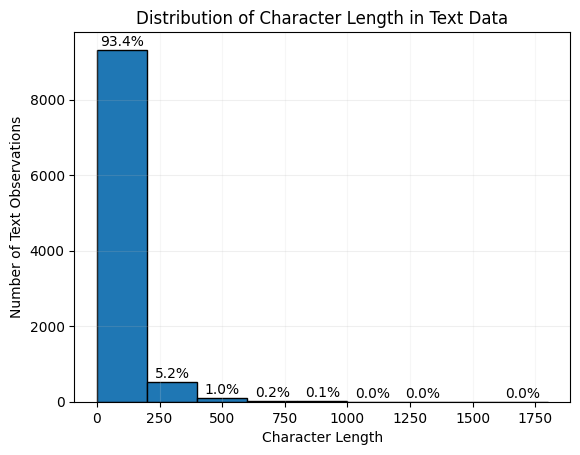

In [5]:
### CHARACTER LENGTH MIN AND MAX ANALYSIS

import matplotlib.pyplot as plt

# Calculate character length for each text and add a new column 'char_length'
trainx['char_length'] = trainx['text'].apply(len)

# Find minimum and maximum character length
min_length = trainx['char_length'].min()
max_length = trainx['char_length'].max()

# Define bin edges for the histogram
bin_edges = [x * 200 for x in range((max_length // 200) + 2)]

# Plot the distribution
fig, ax = plt.subplots()
histogram = ax.hist(trainx['char_length'], bins=bin_edges, edgecolor='black')
plt.xlabel('Character Length')
plt.ylabel('Number of Text Observations')
plt.title('Distribution of Character Length in Text Data')
plt.grid(axis='y', alpha=0.2)  # Set alpha to control grid line opacity
plt.grid(axis='x', color='lightgrey', alpha=0.2)  # Set x-axis grid color and alpha

# Add labels to the bars representing their heights
for val, bin_edge in zip(histogram[0], histogram[1][:-1]):
    if val > 0:
        percentage = val / len(trainx) * 100
        ax.annotate(f'{percentage:.1f}%', xy=(bin_edge + (bin_edges[1] - bin_edges[0]) / 2, val),
                    xytext=(0, 3), textcoords='offset points', ha='center')

plt.show()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
transformer version: 4.26.1
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                        

2023-08-04 13:08:52.767796: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-04 13:08:52.820222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-04 13:08:52.820362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-04 13:08:52.820881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/25
114/313 [=========>....................] - ETA: 0s - loss: 96.0745 - kl_loss: 1.9602 - mse_loss: 94.1143  

2023-08-04 13:08:54.277574: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 1s 1ms/step - loss: 84.3691 - kl_loss: 1.0638 - mse_loss: 83.3052
Epoch 2/25
313/313 [==============================] - 0s 1ms/step - loss: 75.3356 - kl_loss: 0.5983 - mse_loss: 74.7373
Epoch 3/25
313/313 [==============================] - 0s 1ms/step - loss: 74.0834 - kl_loss: 0.7031 - mse_loss: 73.3803
Epoch 4/25
313/313 [==============================] - 0s 1ms/step - loss: 73.4462 - kl_loss: 0.7210 - mse_loss: 72.7252
Epoch 5/25
313/313 [==============================] - 0s 1ms/step - loss: 73.0766 - kl_loss: 0.7459 - mse_loss: 72.3306
Epoch 6/25
313/313 [==============================] - 0s 1ms/step - loss: 72.7458 - kl_loss: 0.8021 - mse_loss: 71.9437
Epoch 7/25
313/313 [==============================] - 0s 1ms/step - loss: 72.2949 - kl_loss: 0.8474 - mse_loss: 71.4475
Epoch 8/25
313/313 [==============================] - 1s 2ms/step - loss: 71.9642 - kl_loss: 0.8753 - mse_loss: 71.0888
Epoch 9/25
313/313 [==============================]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_22969/3781392881.py:537: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/25, Train Loss: 0.6110
Epoch 1/25, Validation Loss: 0.5194

Epoch 2/25, Train Loss: 0.4709
Epoch 2/25, Validation Loss: 0.4422

Epoch 3/25, Train Loss: 0.4346
Epoch 3/25, Validation Loss: 0.4280

Epoch 4/25, Train Loss: 0.4221
Epoch 4/25, Validation Loss: 0.4232

Epoch 5/25, Train Loss: 0.4179
Epoch 5/25, Validation Loss: 0.4187

Epoch 6/25, Train Loss: 0.4155
Epoch 6/25, Validation Loss: 0.4211

Epoch 7/25, Train Loss: 0.4109
Epoch 7/25, Validation Loss: 0.4089

Epoch 8/25, Train Loss: 0.4091
Epoch 8/25, Validation Loss: 0.4112

Epoch 9/25, Train Loss: 0.4065
Epoch 9/25, Validation Loss: 0.4106

Epoch 10/25, Train Loss: 0.4024
Epoch 10/25, Validation Loss: 0.4028

Epoch 11/25, Train Loss: 0.3992
Epoch 11/25, Validation Loss: 0.4063

Epoch 12/25, Train Loss: 0.3983
Epoch 12/25, Validation Loss: 0.4078

Epoch 13/25, Train Loss: 0.3961
Epoch 13/25, Validation Loss: 0.4056

Epoch 14/25, Train Loss: 0.3932
Epoch 14/25, Validation Loss: 0.4031

Epoch 15/25, Train Loss: 0.3918
Epoch 

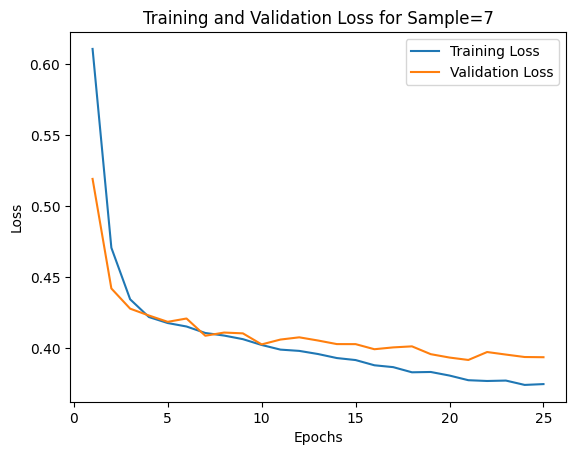

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.825     0.855     0.840      4484
           1      0.850     0.819     0.835      4503

    accuracy                          0.837      8987
   macro avg      0.838     0.837     0.837      8987
weighted avg      0.838     0.837     0.837      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.824     0.834     0.829       506
           1      0.828     0.817     0.822       493

    accuracy                          0.826       999
   macro avg      0.826     0.826     0.826       999
weighted avg      0.826     0.826     0.826       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.881     0.502     0.639       500
           1      0.652     0.932     0.767       500

    accuracy                          0.717      1000
   macro avg      0

/tmp/ipykernel_22969/3781392881.py:586: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:612: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:635: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_p

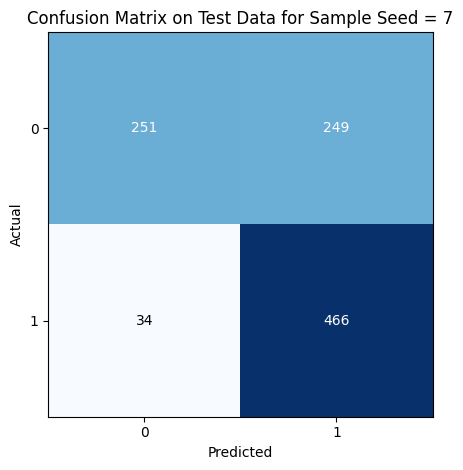

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
transformer version: 4.26.1
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.3 GB
Cached:    0.4 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_2 (Dropout)            (None, 128)          0           ['dense_5[0][0]']                
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_22969/3781392881.py:537: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/25, Train Loss: 0.5656
Epoch 1/25, Validation Loss: 0.4778

Epoch 2/25, Train Loss: 0.4506
Epoch 2/25, Validation Loss: 0.4370

Epoch 3/25, Train Loss: 0.4301
Epoch 3/25, Validation Loss: 0.4243

Epoch 4/25, Train Loss: 0.4258
Epoch 4/25, Validation Loss: 0.4240

Epoch 5/25, Train Loss: 0.4224
Epoch 5/25, Validation Loss: 0.4280

Epoch 6/25, Train Loss: 0.4165
Epoch 6/25, Validation Loss: 0.4240

Epoch 7/25, Train Loss: 0.4142
Epoch 7/25, Validation Loss: 0.4235

Epoch 8/25, Train Loss: 0.4087
Epoch 8/25, Validation Loss: 0.4225

Epoch 9/25, Train Loss: 0.4092
Epoch 9/25, Validation Loss: 0.4094

Epoch 10/25, Train Loss: 0.4056
Epoch 10/25, Validation Loss: 0.4145

Epoch 11/25, Train Loss: 0.4021
Epoch 11/25, Validation Loss: 0.4150

Epoch 12/25, Train Loss: 0.4014
Epoch 12/25, Validation Loss: 0.4132

Epoch 13/25, Train Loss: 0.3982
Epoch 13/25, Validation Loss: 0.4127

Epoch 14/25, Train Loss: 0.3936
Epoch 14/25, Validation Loss: 0.4119

Epoch 15/25, Train Loss: 0.3922
Epoch 

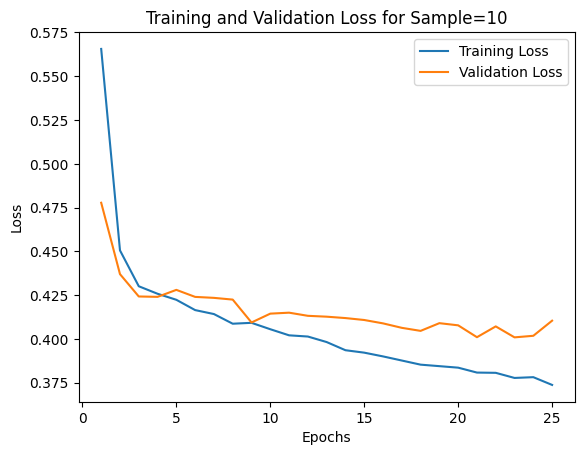

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.831     0.850     0.841      4468
           1      0.848     0.829     0.839      4519

    accuracy                          0.840      8987
   macro avg      0.840     0.840     0.840      8987
weighted avg      0.840     0.840     0.840      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.823     0.837     0.830       522
           1      0.818     0.803     0.811       477

    accuracy                          0.821       999
   macro avg      0.821     0.820     0.820       999
weighted avg      0.821     0.821     0.821       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.892     0.544     0.676       500
           1      0.672     0.934     0.782       500

    accuracy                          0.739      1000
   macro avg      0

/tmp/ipykernel_22969/3781392881.py:586: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:612: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:635: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_p

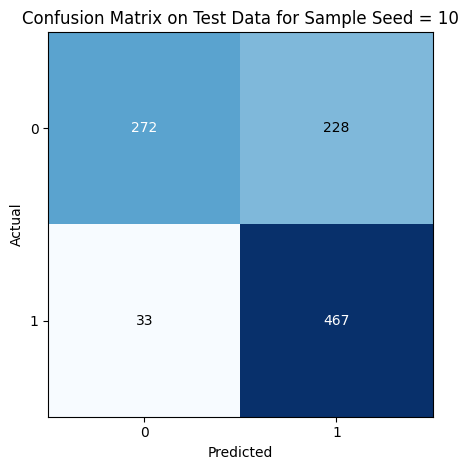

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
transformer version: 4.26.1
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.3 GB
Cached:    0.7 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)            (None, 128)          0           ['dense_10[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_22969/3781392881.py:537: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/25, Train Loss: 0.5659
Epoch 1/25, Validation Loss: 0.4711

Epoch 2/25, Train Loss: 0.4370
Epoch 2/25, Validation Loss: 0.4307

Epoch 3/25, Train Loss: 0.4171
Epoch 3/25, Validation Loss: 0.4154

Epoch 4/25, Train Loss: 0.4106
Epoch 4/25, Validation Loss: 0.4180

Epoch 5/25, Train Loss: 0.4075
Epoch 5/25, Validation Loss: 0.4192

Epoch 6/25, Train Loss: 0.4039
Epoch 6/25, Validation Loss: 0.4090

Epoch 7/25, Train Loss: 0.4028
Epoch 7/25, Validation Loss: 0.4049

Epoch 8/25, Train Loss: 0.3986
Epoch 8/25, Validation Loss: 0.4132

Epoch 9/25, Train Loss: 0.3978
Epoch 9/25, Validation Loss: 0.4182

Epoch 10/25, Train Loss: 0.3936
Epoch 10/25, Validation Loss: 0.4102

Epoch 11/25, Train Loss: 0.3921
Epoch 11/25, Validation Loss: 0.4099

Epoch 12/25, Train Loss: 0.3895
Epoch 12/25, Validation Loss: 0.4065

Epoch 13/25, Train Loss: 0.3875
Epoch 13/25, Validation Loss: 0.4069

Epoch 14/25, Train Loss: 0.3866
Epoch 14/25, Validation Loss: 0.4060

Epoch 15/25, Train Loss: 0.3810
Epoch 

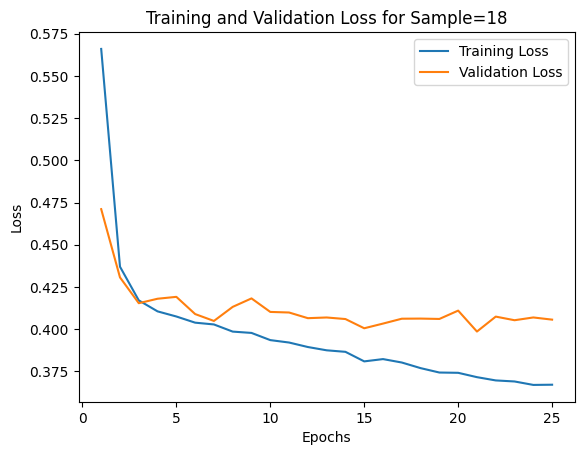

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.835     0.852     0.843      4505
           1      0.848     0.830     0.839      4482

    accuracy                          0.841      8987
   macro avg      0.841     0.841     0.841      8987
weighted avg      0.841     0.841     0.841      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.799     0.821     0.810       485
           1      0.826     0.805     0.816       514

    accuracy                          0.813       999
   macro avg      0.813     0.813     0.813       999
weighted avg      0.813     0.813     0.813       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.893     0.532     0.667       500
           1      0.667     0.936     0.779       500

    accuracy                          0.734      1000
   macro avg      0

/tmp/ipykernel_22969/3781392881.py:586: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:612: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:635: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_p

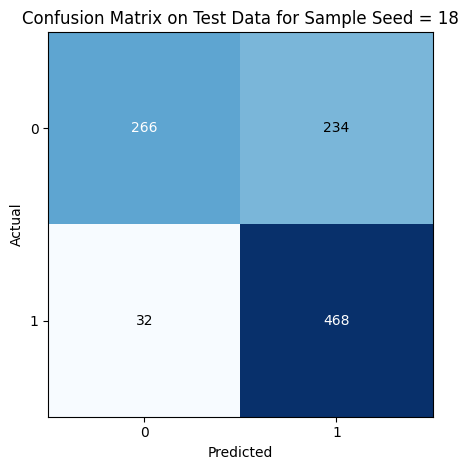

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
transformer version: 4.26.1
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.3 GB
Cached:    0.7 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_6 (Dropout)            (None, 128)          0           ['dense_15[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_22969/3781392881.py:537: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/25, Train Loss: 0.5986
Epoch 1/25, Validation Loss: 0.4984

Epoch 2/25, Train Loss: 0.4594
Epoch 2/25, Validation Loss: 0.4453

Epoch 3/25, Train Loss: 0.4321
Epoch 3/25, Validation Loss: 0.4377

Epoch 4/25, Train Loss: 0.4278
Epoch 4/25, Validation Loss: 0.4411

Epoch 5/25, Train Loss: 0.4217
Epoch 5/25, Validation Loss: 0.4335

Epoch 6/25, Train Loss: 0.4180
Epoch 6/25, Validation Loss: 0.4291

Epoch 7/25, Train Loss: 0.4159
Epoch 7/25, Validation Loss: 0.4303

Epoch 8/25, Train Loss: 0.4145
Epoch 8/25, Validation Loss: 0.4276

Epoch 9/25, Train Loss: 0.4105
Epoch 9/25, Validation Loss: 0.4291

Epoch 10/25, Train Loss: 0.4082
Epoch 10/25, Validation Loss: 0.4255

Epoch 11/25, Train Loss: 0.4083
Epoch 11/25, Validation Loss: 0.4263

Epoch 12/25, Train Loss: 0.4038
Epoch 12/25, Validation Loss: 0.4224

Epoch 13/25, Train Loss: 0.4015
Epoch 13/25, Validation Loss: 0.4261

Epoch 14/25, Train Loss: 0.3985
Epoch 14/25, Validation Loss: 0.4236

Epoch 15/25, Train Loss: 0.3960
Epoch 

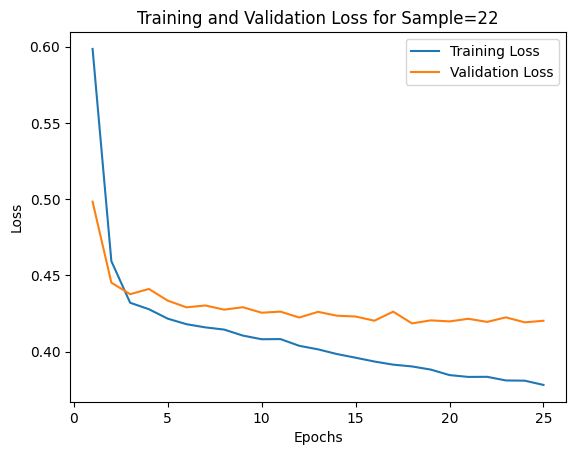

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.824     0.851     0.837      4492
           1      0.846     0.818     0.832      4495

    accuracy                          0.835      8987
   macro avg      0.835     0.835     0.834      8987
weighted avg      0.835     0.835     0.834      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.783     0.841     0.811       498
           1      0.830     0.768     0.798       501

    accuracy                          0.805       999
   macro avg      0.806     0.805     0.805       999
weighted avg      0.807     0.805     0.805       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.868     0.566     0.685       500
           1      0.678     0.914     0.779       500

    accuracy                          0.740      1000
   macro avg      0

/tmp/ipykernel_22969/3781392881.py:586: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:612: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:635: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_p

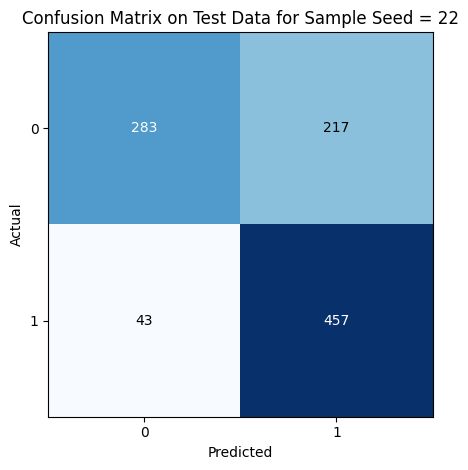

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
transformer version: 4.26.1
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.3 GB
Cached:    0.7 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 128)          0           ['dense_20[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_22969/3781392881.py:537: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/25, Train Loss: 0.6065
Epoch 1/25, Validation Loss: 0.4993

Epoch 2/25, Train Loss: 0.4684
Epoch 2/25, Validation Loss: 0.4239

Epoch 3/25, Train Loss: 0.4354
Epoch 3/25, Validation Loss: 0.4146

Epoch 4/25, Train Loss: 0.4275
Epoch 4/25, Validation Loss: 0.4163

Epoch 5/25, Train Loss: 0.4254
Epoch 5/25, Validation Loss: 0.4121

Epoch 6/25, Train Loss: 0.4227
Epoch 6/25, Validation Loss: 0.4088

Epoch 7/25, Train Loss: 0.4172
Epoch 7/25, Validation Loss: 0.4051

Epoch 8/25, Train Loss: 0.4166
Epoch 8/25, Validation Loss: 0.4009

Epoch 9/25, Train Loss: 0.4136
Epoch 9/25, Validation Loss: 0.4034

Epoch 10/25, Train Loss: 0.4101
Epoch 10/25, Validation Loss: 0.4040

Epoch 11/25, Train Loss: 0.4065
Epoch 11/25, Validation Loss: 0.4008

Epoch 12/25, Train Loss: 0.4032
Epoch 12/25, Validation Loss: 0.4001

Epoch 13/25, Train Loss: 0.3990
Epoch 13/25, Validation Loss: 0.3985

Epoch 14/25, Train Loss: 0.3974
Epoch 14/25, Validation Loss: 0.4019

Epoch 15/25, Train Loss: 0.3944
Epoch 

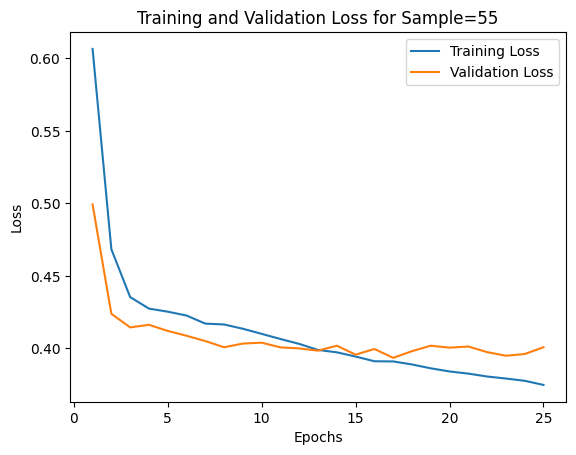

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.825     0.855     0.840      4494
           1      0.849     0.819     0.834      4493

    accuracy                          0.837      8987
   macro avg      0.837     0.837     0.837      8987
weighted avg      0.837     0.837     0.837      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.812     0.847     0.829       496
           1      0.842     0.807     0.824       503

    accuracy                          0.827       999
   macro avg      0.827     0.827     0.827       999
weighted avg      0.827     0.827     0.827       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.890     0.484     0.627       500
           1      0.646     0.940     0.765       500

    accuracy                          0.712      1000
   macro avg      0

/tmp/ipykernel_22969/3781392881.py:586: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:612: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:635: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_p

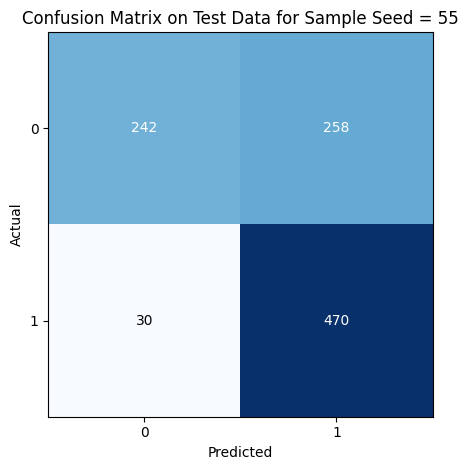

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train embeddings shape: (9986, 32)
test embeddings shape: (1000, 32)
transformer version: 4.26.1
cuda
NVIDIA GeForce RTX 3070 Laptop GPU
Memory Usage:
Allocated: 0.3 GB
Cached:    0.7 GB
len of common strings 9986
torch.Size([9986, 512])
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 512)]        0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 128)          65664       ['encoder_input[0][0]']          
                                                                                                  
 dropout_10 (Dropout)           (None, 128)          0           ['dense_25[0][0]']               
                                                        

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fusion Embeddings Train (9986, 96)
Fusion Embeddings Test (1000, 96)
train data shape:  torch.Size([8987, 96]) validation data shape:  torch.Size([999, 96]) test embd shape: (1000, 96)


/tmp/ipykernel_22969/3781392881.py:537: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:556: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()


Epoch 1/25, Train Loss: 0.5917
Epoch 1/25, Validation Loss: 0.4960

Epoch 2/25, Train Loss: 0.4556
Epoch 2/25, Validation Loss: 0.4317

Epoch 3/25, Train Loss: 0.4250
Epoch 3/25, Validation Loss: 0.4207

Epoch 4/25, Train Loss: 0.4173
Epoch 4/25, Validation Loss: 0.4144

Epoch 5/25, Train Loss: 0.4127
Epoch 5/25, Validation Loss: 0.4103

Epoch 6/25, Train Loss: 0.4084
Epoch 6/25, Validation Loss: 0.4157

Epoch 7/25, Train Loss: 0.4066
Epoch 7/25, Validation Loss: 0.4086

Epoch 8/25, Train Loss: 0.4022
Epoch 8/25, Validation Loss: 0.4093

Epoch 9/25, Train Loss: 0.4010
Epoch 9/25, Validation Loss: 0.4065

Epoch 10/25, Train Loss: 0.3980
Epoch 10/25, Validation Loss: 0.4069

Epoch 11/25, Train Loss: 0.3949
Epoch 11/25, Validation Loss: 0.4060

Epoch 12/25, Train Loss: 0.3941
Epoch 12/25, Validation Loss: 0.4076

Epoch 13/25, Train Loss: 0.3914
Epoch 13/25, Validation Loss: 0.4030

Epoch 14/25, Train Loss: 0.3902
Epoch 14/25, Validation Loss: 0.4022

Epoch 15/25, Train Loss: 0.3867
Epoch 

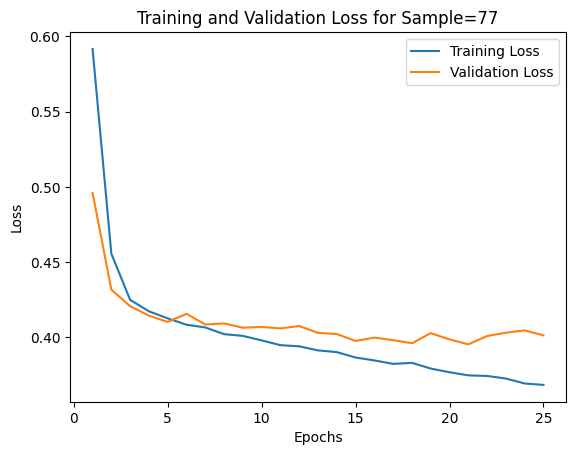

Training Data Classification Report:
              precision    recall  f1-score   support

           0      0.837     0.857     0.847      4522
           1      0.852     0.831     0.841      4465

    accuracy                          0.844      8987
   macro avg      0.845     0.844     0.844      8987
weighted avg      0.845     0.844     0.844      8987

Validation Data Classification Report:
              precision    recall  f1-score   support

           0      0.782     0.829     0.805       468
           1      0.841     0.797     0.818       531

    accuracy                          0.812       999
   macro avg      0.812     0.813     0.812       999
weighted avg      0.813     0.812     0.812       999

Test Data Classification Report:
              precision    recall  f1-score   support

           0      0.893     0.502     0.643       500
           1      0.654     0.940     0.771       500

    accuracy                          0.721      1000
   macro avg      0

/tmp/ipykernel_22969/3781392881.py:586: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:612: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
/tmp/ipykernel_22969/3781392881.py:635: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels_p

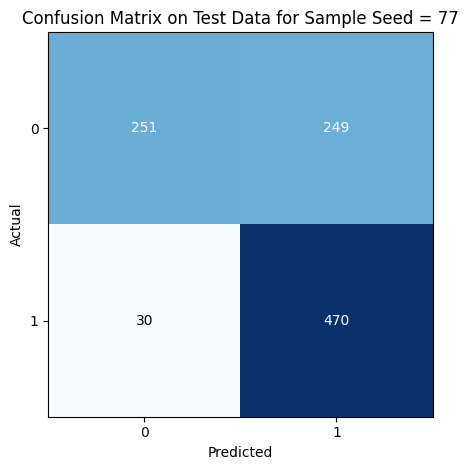

In [6]:
PERFORMANCE_RESULTS = pd.DataFrame(columns=['Model', 'EvalSet', 'Accuracy', 
                       'M-Precision', 'M-Recall', 
                       'M-F1-Score', 'W-Precision',
                       'W-Recall', 'W-F1-Score'])

mse_val1 = []
KL_LOSS1 = []


for KK in list([7,10,18,22,55,77]): 

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)


    device = "cpu"
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    #     tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertModel.from_pretrained("distilbert-base-uncased")
    model.to(device)
    projection_layer = torch.nn.Linear(768, 32)  # Add a linear layer to project embeddings to size 64
    projection_layer.to(device)

    train_encodings = tokenizer(
        train["text"].apply(apply_text_perturbation).tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings = tokenizer(
        test["text"].tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )


    with torch.no_grad():
        train_outputs = model(**train_encodings.to(device))
        train_embeddings = train_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings = projection_layer(train_embeddings)  # Project embeddings to size 65

        test_outputs = model(**test_encodings.to(device))
        test_embeddings = test_outputs.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings = projection_layer(test_embeddings)  # Project embeddings to size 65

    train_embeddings = train_embeddings.cpu().numpy()
    test_embeddings = test_embeddings.cpu().numpy()

    print("train embeddings shape:", train_embeddings.shape)
    print("test embeddings shape:", test_embeddings.shape)



    # CLIP Image Embeddings (Training Image Embeddings)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP



    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


    # model_16

    # Define the directory containing the images
    IDs = []  #set1
    images = []
    
    image_dir = "/home/nitesh/Documents/MY_THESIS/MAMI/TRAINING"
    # # Load the data
    train2 = pd.read_csv('/home/nitesh/Documents/MY_THESIS/MAMI/training1.csv', delimiter='\t')

    # Get a list of image filenames in the directory
    filenames = natsort.natsorted(os.listdir(image_dir))
    # len(image_filenames)

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(filenames):
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            ID = filename
            pathname = os.path.join(image_dir, filename)
            im = Image.open(pathname)
    #         print(im.size)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            imnp = np.array(im)
            if len(imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue
            IDs.append(ID)
            images.append(imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    list1 = IDs
    list2 = list(train2.file_name)  #from the text file where we have text description 
    common_strings = get_common_strings(list1, list2)
    print('len of common strings', len(common_strings))

    image_filenames = natsort.natsorted(common_strings)
    # display(image_filenames)

    import pandas as pd

    train_labelset = train2[['file_name', 'misogynous']]
    IDs_df = pd.DataFrame({'file_name': image_filenames})
    joined_df = IDs_df.merge(train_labelset, on='file_name', how='left')
    misogynous_labels = joined_df['misogynous'].tolist()


    # Create an empty list to store the image features
    all_image_features_16 = []


    model_16, preprocess_16 = clip.load('ViT-B/16', device=device)

    # Process each image and extract features
    for filename in image_filenames:
        image_path = os.path.join(image_dir, filename)

        # Preprocess the image
        image_16 = preprocess_16(Image.open(image_path)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features_16 = model_16.encode_image(image_16)

        # Append the image features to the list
        all_image_features_16.append(image_features_16)

    # Concatenate the image features into a single tensor
    all_image_features_16 = torch.cat(all_image_features_16, dim=0)
    print(all_image_features_16.shape)
    # torch.Size([9986, 512])



    ## REDUCE 512 EMBEDDING SIZE TO 32 EMBEDDING SIZE #####
    #######################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    embedding_size = 32
    all_image_features_16_cpu = all_image_features_16.cpu()
    all_image_features_16_numpy = all_image_features_16_cpu.numpy()



    ## using the below Sampling class from WK08 lab tutorials. 
    class Sampling(layers.Layer):


        """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
            Sampling from the distribution of z_mu and z_var helps in 
            generating new point in latent space which we can pass to the decoder network 
            to reconstruct the data samples similar to original input
        """
        def call(self, inputs):

            #the encoder network produces a mean and a variance for each dimension of the latent space.
            z_mean, z_log_var = inputs

            # epsilon is not a weight (ie is not learned) and is not calculated based on 
            # the output of the previous layer.
            # epsilon is just a constant Tensor (a new one, each time we call this layer).


            epsilon = K.random_normal(shape=tf.shape(z_mean)) # N(0, 1)
            return z_mean + K.exp(0.5 * z_log_var) * epsilon # N(mu, sigma)


    # for the encoder part, now the original dimension would be the pretrained model output flattened features
    # dimension
    original_dim = all_image_features_16_numpy.shape[1] 
    intermediate_dim = 128  
    intermediate_dim_1 = 32

    latent_dim = embedding_size  # i.e. 18, we set latent dimension to be of embedding size i.e. 18.

    # Define Input to the encoder 
    #Encoder Model Structure
    original_inputs = layers.Input(shape=(original_dim,), name="encoder_input")
    x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim_1, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))   #updated
    encoder = models.Model(inputs=original_inputs, outputs=z, name="encoder") 
    # encoder = models.Model(inputs=original_inputs, outputs=[z_mean, z_log_var], name="encoder")


    #decoder model
    latent_inputs = layers.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(intermediate_dim_1, activation="relu")(latent_inputs)
    x = Dropout(0.0001)(x) # add dropout with  tiny probability because data is small
    x = layers.Dense(intermediate_dim, activation="relu")(x)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)
    decoder = models.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

    # z = Sampling()((z_mean, z_log_var))
    outputs = decoder(z)
    vae = models.Model(inputs=original_inputs, outputs=outputs, name="vae")
    vae.summary()

    #get the reconstruction loss
    reconstruction_loss = mse(original_inputs, outputs) # xhat should match x
    reconstruction_loss = original_dim * K.mean(reconstruction_loss)

    # regularization KL divergence term encourages the learned latent space to be a smooth manifold.
    kl_loss = -0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    vae.add_loss(kl_loss)
    vae.add_metric(kl_loss, name='kl_loss', aggregation='mean')
    vae.add_loss(reconstruction_loss)
    vae.add_metric(reconstruction_loss, name='mse_loss', aggregation='mean')

    # set Adam optimizer with learning ate 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    #Compile the model 
    vae.compile(optimizer)

    # Train. x_train is both the "x" and the "y"
    # vae.fit(flat_features, flat_features, epochs=10)

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    vaemod = vae.fit(all_image_features_16_numpy, all_image_features_16_numpy, epochs=25)
    # Increasing the epochs performing badly when we run k-neareast neighbour to achieve the 
    # nearest posters. 

    #In this code, we first need to build the vae model before using encoder.predict(). 
    #This is because the encoder model is a part of the vae model and needs to be built first.

    ## KL LOSS

    KL_LOSS =  vaemod.history['kl_loss']

    KL_LOSS1.append(KL_LOSS)

    mse_val =  vaemod.history['mse_loss']
    print(mse_val)

    mse_val1.append(mse_val)


    latent_emb = encoder.predict(all_image_features_16_numpy)  
    # z_mean, z_log_var = encoder.predict(all_image_features_16_numpy)
    # latent_emb = Sampling()((z_mean, z_log_var))
    print(latent_emb.shape) 

    #Additional Info when using cuda
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')





    # CLIP Image Embeddings (Test Image Embeddings)

    # TEST DATA IMAGES LOADING


    TEST_IDs = []  #set1
    TEST_images = []
#     TEST_directory='../TEST/'
    TEST_directory = '/home/nitesh/Documents/MY_THESIS/MAMI/TEST'   # directory where we have images 
    test_filenames = natsort.natsorted(os.listdir(TEST_directory))  

    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(test_filenames):
    #     print(i, filename)
        if filename.endswith(".jpg"):
    #         ID = int(filename[:-4])
            TEST_ID = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_imnp = np.array(im)
            if len(TEST_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_imnp.shape, filename)
                continue
            TEST_IDs.append(TEST_ID)
            TEST_images.append(TEST_imnp)


    # Align the image and textual data and extract where we have both available 
    def get_common_strings(list1, list2):
        return list(set(list1) & set(list2))

    # Example usage
    TEST_list1 = TEST_IDs
    TEST_list2 = list(test2.file_name)  #from the text file where we have text description 
    TEST_common_strings = get_common_strings(TEST_list1, TEST_list2)
    print('len of common strings', len(TEST_common_strings))

    TEST_sorted_ids = natsort.natsorted(TEST_common_strings)
    # len(TEST_sorted_ids)


    TEST_IDs1 = []
    TEST_images1 = [] 
    # Correct the images as some images are not having 3 channels.Omit such images.
    # get the ids from the images, where images are having three channels; omit images if channels != 3
    for i, filename in enumerate(TEST_sorted_ids):
    #     print(i, filename)
        if filename.endswith(".jpg"):
            TEST_ID_0 = filename
            pathname = os.path.join(TEST_directory, filename)
            im = Image.open(pathname)
            im = im.resize((224, 224))  # Resize the image to (224, 224)
            TEST_1_imnp = np.array(im)
            if len(TEST_1_imnp.shape) != 3:
    #             print("This is 1 channel, so we omit it", TEST_1_imnp.shape, filename)
                continue
    #         print('Filename', TEST_ID_0)
            TEST_IDs1.append(TEST_ID_0)
            TEST_images1.append(TEST_1_imnp)


    len(TEST_images1), len(TEST_IDs1)


    #### TEST EMBEDDINGS #####
    clip_test_embeddings = []

    for image in TEST_images1:
        # Preprocess the image
        image_tensor = preprocess_16(Image.fromarray(image)).unsqueeze(0).to(device)

        # Encode the image features
        with torch.no_grad():
            image_features = model_16.encode_image(image_tensor)

        # Append the image features to the list
        clip_test_embeddings.append(image_features)

    clip_test_embeddings = torch.cat(clip_test_embeddings, dim=0)

    # Move the test embeddings tensor to the CPU
    clip_test_embeddings = clip_test_embeddings.cpu()

    # Convert the test embeddings tensor to a NumPy array
    clip_test_embeddings_np = clip_test_embeddings.numpy()

    # Use the existing encoder to reduce the dimensions of the test embeddings
    reduced_test_embeddings  = encoder.predict(clip_test_embeddings_np)
    # z_mean_clipmod, z_log_var_clipmod = encoder.predict(clip_test_embeddings_np)
    # reduced_test_embeddings = Sampling()((z_mean_clipmod, z_log_var_clipmod))

    print('Image Test Embeddings Dimension', reduced_test_embeddings.shape)

    os.chdir('/home/nitesh/Documents/MY_THESIS/MAMI')

    if os.getcwd() != "/home/nitesh/Documents/MY_THESIS/MAMI/BLIP":
        %cd BLIP
    print(os.getcwd())

    # Load the training captions data and test captions data files. 
    train_capn = pd.read_csv('train_BLIP_captions.csv')

    test_capn = pd.read_csv('test_BLIP_captions.csv')


    ###########################################################

    # Apply text perturbation to the training captions
    train_capn["text"] = train_capn["text"].apply(apply_text_perturbation)


    ############################################################

    random.seed(KK)
    np.random.seed(KK)
    torch.manual_seed(KK)
    tf.random.set_seed(KK)

    print('transformer version:', transformers.__version__)
    # !git clone https://github.com/salesforce/BLIP
    # Ref: https://github.com/salesforce/BLIP

    from transformers import DistilBertTokenizer, DistilBertModel
    tokenizer1 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model1 = DistilBertModel.from_pretrained("distilbert-base-uncased")


    device = "cpu"
    model1.to(device)
    projection_layer1 = torch.nn.Linear(768, 32)  # Add a linear layer to project embeddings to size 64
    projection_layer1.to(device)

    train_encodings1 = tokenizer1(
        train_capn["text"].tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )

    test_encodings1 = tokenizer1(
        test_capn["text"].tolist(),
        padding=True,
        max_length=50,
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        train_outputs1 = model1(**train_encodings1.to(device))
        train_embeddings1 = train_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        train_embeddings1 = projection_layer1(train_embeddings1)  # Project embeddings to size 65

        test_outputs1 = model1(**test_encodings1.to(device))
        test_embeddings1 = test_outputs1.last_hidden_state[:, 0, :]  # Extract embeddings for the [CLS] token
        test_embeddings1 = projection_layer1(test_embeddings1)  # Project embeddings to size 65


    # Concatenate the text and image embeddings
    fusion_embeddings_train = np.concatenate((train_embeddings, latent_emb, train_embeddings1), axis=1)
    print('Fusion Embeddings Train', fusion_embeddings_train.shape)


    # Concatenate the text and image embeddings
    fusion_embeddings_test = np.concatenate((test_embeddings, reduced_test_embeddings, test_embeddings1), 
                                            axis=1)
    print('Fusion Embeddings Test', fusion_embeddings_test.shape)


    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print(device)
    from sklearn.model_selection import train_test_split
    device='cpu'
    train_lbls = train.label.map({'non_misogyn': 0, 'misogyn': 1}).to_list()
    # train_labels= train_lbls

    test_lbls = test.label.map({'non_misogyn': 0, 'misogyn': 1}).to_list()
    # test_labels= test_lbls


    seed_value = KK
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    fusion_embeddings_train_pt = torch.tensor(fusion_embeddings_train).to(device)
    fusion_embeddings_test_pt = torch.tensor(fusion_embeddings_test).to(device)

    train_labels_pt = torch.tensor(train_lbls).to(device)
    test_labels_pt = torch.tensor(test_lbls).to(device)


    # Split the data into train and validation sets
    train_embeddings1, val_embeddings1, train_labels1, val_labels1 = train_test_split(fusion_embeddings_train_pt, 
                                                                                      train_labels_pt, 
                                                                                      test_size=0.1, 
                                                                                      random_state=KK)

    print("train data shape: ", train_embeddings1.shape, "validation data shape: ", val_embeddings1.shape,
         'test embd shape:', fusion_embeddings_test.shape)


    # Define the multiclass classification model
    class MulticlassClassifier(nn.Module):
        def __init__(self, input_size, num_classes):
            super(MulticlassClassifier, self).__init__()
            self.fc1 = nn.Linear(input_size, 128)
            self.fc2 = nn.Linear(128, num_classes)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.2)

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.dropout(out)
            out = self.fc2(out)
            return out

    import torch.optim as optim

    model_NN = MulticlassClassifier(input_size=train_embeddings1.shape[1], 
                                    num_classes=len(set(train_lbls)))

    model_NN = model_NN.to(device)  # Move model to CUDA GPU
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    # Train the model
    num_epochs = 25
    batch_size = 16

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
            epoch_loss = 0.0

            for i in range(0, len(train_embeddings1), batch_size):
                batch_embeddings = train_embeddings1[i:i+batch_size].requires_grad_(True).to(device)  # Move tensor to CUDA GPU
                batch_labels = train_labels1[i:i+batch_size]
                batch_labels = torch.tensor(batch_labels).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU

                # Forward pass
                train_outputs = model_NN(batch_embeddings)
                loss = criterion(train_outputs, batch_labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()  # Accumulate the loss

            avg_train_loss = epoch_loss / (len(train_embeddings1) // batch_size)  # Calculate average training loss
            train_losses.append(avg_train_loss)

                    # Evaluate the model on the validation set
            with torch.no_grad():
                val_embeddings2 = val_embeddings1.to(device)
                val_labels2 = torch.tensor(val_labels1).clone().detach().to(device).long()
                val_outputs = model_NN(val_embeddings2)
                val_loss = criterion(val_outputs, val_labels2)

            val_losses.append(val_loss.item())

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss.item():.4f}")
            print()

            # Plotting the loss curves
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for Sample={KK}')
    plt.legend()
    plt.show()


    


    modname  = 'DistilBERT_CLIP_VAE_BLIP_NN_VOWELPERTURB'

    # Evaluate the model on training set
    model_NN.eval()
    with torch.no_grad():
        train_emb = train_embeddings1.to(device)  # Move tensor to CUDA GPU
        train_lbls = torch.tensor(train_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
        train_otpt = model_NN(train_emb)


    # Convert the predicted values and original test labels to CPU
    train_preds = train_otpt.to('cpu').argmax(dim=1).numpy()
    train_labelsx=np.array(train_labels1)

    # Generate classification report
    print("Training Data Classification Report:")
    eval_set='training'
    classification_rep_train = classification_report(train_labelsx, train_preds, digits=3)
    print(classification_rep_train)

    results_train= export_classification_report(classification_rep_train, modname, eval_set='training')
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_train])

    
    



    # Evaluate the model on validation set
    model_NN.eval()
    with torch.no_grad():
        val_emb = val_embeddings1.to(device)  # Move tensor to CUDA GPU
        val_lbls = torch.tensor(val_labels1).clone().detach().to(device).long() # Convert to PyTorch tensor and move to CUDA GPU
        val_otpt = model_NN(val_emb)
    #     test_loss = criterion(val_otpt, val_lbls)    

    # Convert the predicted values and original test labels to CPU
    val_preds = val_otpt.to('cpu').argmax(dim=1).numpy()
    val_labelsx=np.array(val_labels1)

    print("Validation Data Classification Report:")
    eval_set='validation'
    classification_rep_val = classification_report(val_labelsx, val_preds, digits=3)
    print(classification_rep_val)
    results_val= export_classification_report(classification_rep_val, modname, eval_set='validation')
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_val])


    
    
    
    # Evaluate the model on test set
    model_NN.eval()
    with torch.no_grad():
        test_embeddings = fusion_embeddings_test_pt.to(device)  # Move tensor to CUDA GPU
        test_labels = torch.tensor(test_labels_pt).to(device).long()  # Convert to PyTorch tensor and move to CUDA GPU
        test_outputs = model_NN(test_embeddings)
        test_loss = criterion(test_outputs, test_labels)

    # Convert the predicted values and original test labels to CPU
    test_preds = test_outputs.to('cpu').argmax(dim=1).numpy()
    test_labels = test_labels.to('cpu').numpy()

    print("Test Data Classification Report:")
    classification_rep_test = classification_report(test_labels, test_preds, digits=3)
    print(classification_rep_test)
    results_test= export_classification_report(classification_rep_test, modname, eval_set='test')
    PERFORMANCE_RESULTS = pd.concat([PERFORMANCE_RESULTS, results_test])

    class_labels = [0,1]
    class_labels1 = ['non_misogyn', 'misogyn']
    confusion_mat = confusion_matrix(test_labels, test_preds, labels=class_labels)
    print("Confusion Matrix:")
    # print(confusion_mat)
    confusion_df = pd.DataFrame(confusion_mat, index=class_labels1, columns=class_labels1)
    print(confusion_df)
    # Plot the confusion matrix with filled colors
    plt.imshow(confusion_mat, cmap='Blues', interpolation='nearest')

    # Add labels and title
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=0)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix on Test Data for Sample Seed = {KK}')

    # Add text annotations in each cell
    thresh = confusion_mat.max() / 2
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            plt.text(j, i, format(confusion_mat[i, j], 'd'), ha="center", va="center",
                     color="white" if confusion_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    del class_labels, class_labels1, train_emb, test_embeddings, train_embeddings1, val_emb

In [7]:
PERFORMANCE_RESULTS

,Model,EvalSet,Accuracy,M-Precision,M-Recall,M-F1-Score,W-Precision,W-Recall,W-F1-Score
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,training,0.837,0.838,0.837,0.837,0.838,0.837,0.837
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,validation,0.826,0.826,0.826,0.826,0.826,0.826,0.826
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.717,0.766,0.717,0.703,0.766,0.717,0.703
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,training,0.840,0.840,0.840,0.840,0.840,0.840,0.840
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,validation,0.821,0.821,0.820,0.820,0.821,0.821,0.821
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.739,0.782,0.739,0.729,0.782,0.739,0.729
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,training,0.841,0.841,0.841,0.841,0.841,0.841,0.841
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,validation,0.813,0.813,0.813,0.813,0.813,0.813,0.813
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.734,0.780,0.734,0.723,0.780,0.734,0.723
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,training,0.835,0.835,0.835,0.834,0.835,0.835,0.834


In [8]:
# Filter the DataFrame based on the 'CATEGORY' column
PERFORMANCE_RESULTS1 = PERFORMANCE_RESULTS[PERFORMANCE_RESULTS['EvalSet'] == 'test']

# Print the filtered DataFrame
display(PERFORMANCE_RESULTS1)

,Model,EvalSet,Accuracy,M-Precision,M-Recall,M-F1-Score,W-Precision,W-Recall,W-F1-Score
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.717,0.766,0.717,0.703,0.766,0.717,0.703
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.739,0.782,0.739,0.729,0.782,0.739,0.729
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.734,0.780,0.734,0.723,0.780,0.734,0.723
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.740,0.773,0.740,0.732,0.773,0.740,0.732
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.712,0.768,0.712,0.696,0.768,0.712,0.696
0,DistilBERT_ViT_VAE_BLIP_NN_VOWELPERTURB,test,0.721,0.773,0.721,0.707,0.773,0.721,0.707


In [9]:
np.average(PERFORMANCE_RESULTS1['M-F1-Score'])

0.7149999999999999

In [16]:
PERFORMANCE_RESULTS1.to_excel('../../MAMI/14_classification_report_DistilBERT_CLIP_BLIP_NN_VOWELPERTURB_715.xlsx', 
                      index=False)

## Variational Autoencoder MSE Plots 

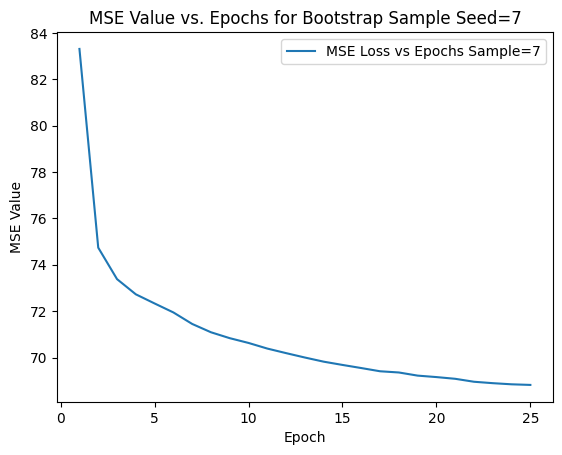

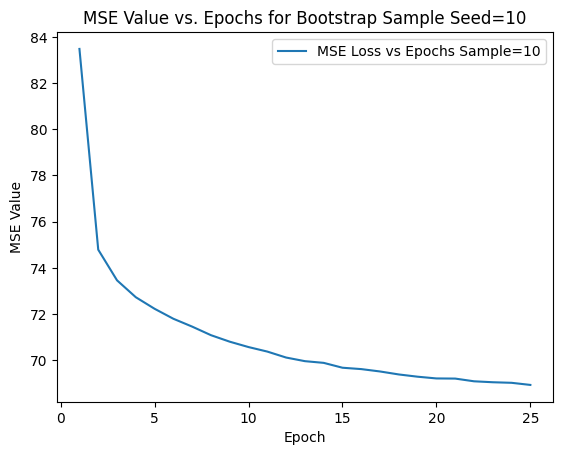

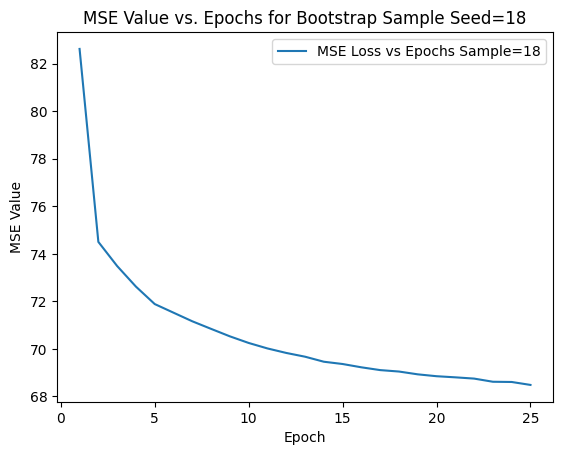

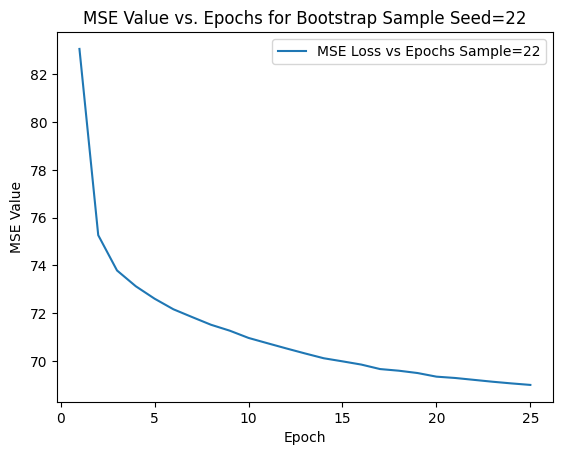

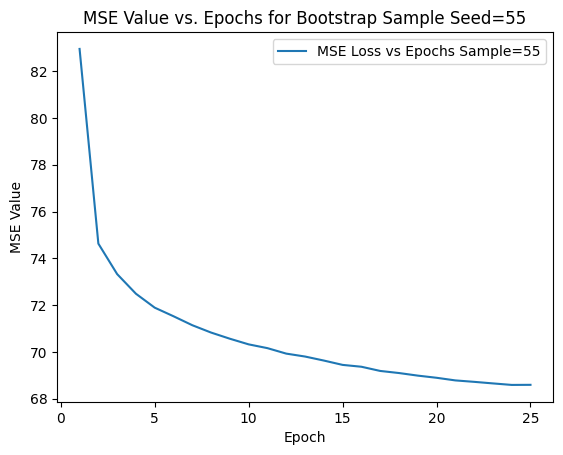

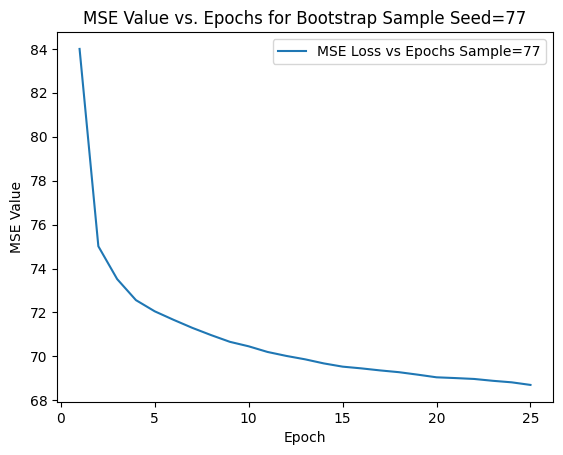

In [15]:
# os.getcwd()
num_lists = len(mse_val1)  # Number of lists
epochs_vae = range(1, 26)  # Epochs (assuming 10 epochs)


# Plot each list in mse_val1
for i, j in zip(range(num_lists), list([7,10,18,22,55,77])):         
    plt.plot(epochs_vae, mse_val1[i], label=f'MSE Loss vs Epochs Sample={j}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Value')
    plt.title(f'MSE Value vs. Epochs for Bootstrap Sample Seed={j}')
    plot_path = '/home/nitesh/Documents/MY_THESIS/MAMI/Plots_VAE/'
    plt.savefig(plot_path + f'13_VAE_TrainingLoss_Epoch_Plot_VOWELPERTURB{j}.png')
    plt.legend()
    plt.show()
    plt.close()  # Close the connection 

In [12]:
# References:

https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/

https://deepchecks.com/a-comprehensive-guide-into-shap-shapley-additive-explanations-values/

https://medium.com/data-science-in-your-pocket/shap-for-interpreting-ml-models-explained-with-codes-e94baf5a204e